# **COMPUTER VISION PROJECT 1** 

# Now first of all, lets mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Now Lets install all the library


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
#supervised learning model library

from sklearn import svm, metrics
from natsort import natsorted
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import confusion_matrix
import itertools
from keras.callbacks import ReduceLROnPlateau
#Deep learning library

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
import cv2
import os
import itertools
from sklearn.preprocessing import LabelBinarizer
from google.colab.patches import cv2_imshow
import tensorflow
from tensorflow.keras.layers import Dense, Dropout, InputLayer, BatchNormalization, Flatten,GlobalAveragePooling2D, Conv2D, MaxPool2D, GlobalMaxPool2D

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error

from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam



# Now define the path of the folder by the help of cd. So that we can import all the data from that path. and can do further analysis 

In [ ]:
cd "/content/drive/MyDrive/AIML Program/Project/CV 1 - Project"

/content/drive/MyDrive/AIML Program/Project/CV 1 - Project


Now lets see, all the label in the train folder.

In [ ]:
directory = glob.glob("train/*")
x = [os.path.split(i)[-1] for i in directory]
x

['Common wheat',
 'Maize',
 'Common Chickweed',
 'Fat Hen',
 'Small-flowered Cranesbill',
 'Loose Silky-bent',
 'Cleavers',
 'Shepherds Purse',
 'Sugar beet',
 'Scentless Mayweed',
 'Charlock',
 'Black-grass']

Now lets visualize the image in these label. So that we can have some basic idea about these pictures.

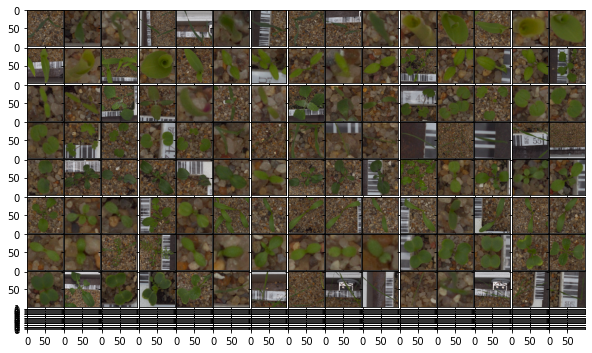

In [ ]:
fig = plt.figure(1, (10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(20, 15))
Image = []
random = 0
for i, label in enumerate(x):
    paths = glob.glob(os.path.join("train", label, "*.png"))
    Image.append([label, len(paths)])
    y = np.random.choice(len(paths), size=10)    
    for z in y:
        axis = grid[random]        
        image = cv2.imread(paths[z])
        image = cv2.resize(image, (100, 100))    
        axis.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        random =random+1        
plt.show()

Now here we'll have to save this path into a variable so that we can fetch it easily whenever required

In [ ]:
from glob import glob
data = "train"

In [ ]:
images = []
classes=[]
z=0
for x in os.listdir(data):
    path = os.path.join(data, x)
    class_label = x    
    for y in glob(os.path.join(path, "*.png")):
        b = cv2.imread(y, cv2.IMREAD_COLOR)
        if b is None: 
          z =z+1
          continue
        images.append(b)        
        classes.append(class_label)

Number of images available in the dataset

In [ ]:
len(images)


4767

# As we have seen in the dataset that size of all the images are different from each other. so we'll have to make it into equal size so that we can perform the task on it. SO for that we'll resize every image into the dimension of 256*256 

In [ ]:
def resize_images(img):
  img = np.array(img).astype(np.uint8)  
  a = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return a

We have applied the function on it. so its see what we have got.

In [ ]:
images = [resize_images(img) for img in images]

In [ ]:
images = np.array(images)
classes = np.array(classes)
images.shape

(4767, 256, 256, 3)

Here we can see that all image shape got converted into size of the dimension of 256*256

So Now lets see the shape of the classes available in the datset

In [ ]:
classes.shape

(4767,)

Now lets see the number of images available in each set. for that we'll visualize the data by bar chart.

In [ ]:
values =[]
labels=[]
for x in set(classes):
  values.append(len(images[classes == x]))
  labels.append(x)
x=np.arange(0,13,1)


We have taken here the figure size of 7*5, and rotation of x axis values by 90 degree.

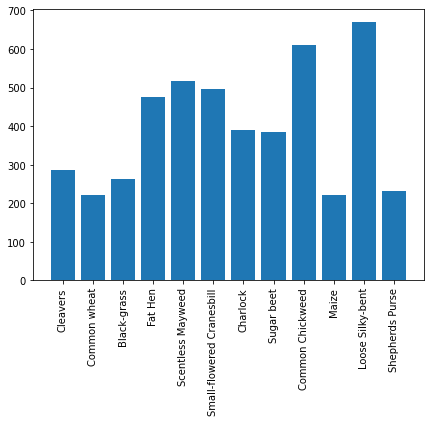

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(labels, values)
plt.xticks(rotation=90)
plt.show()

# As we can see here that Maize and Common wheat have the lowest number of images available compared to other classes. On the other hand Loose Silky-bent have the highest number of images available.

# Now lets explore the some more images available, so that we can have some understanding about it.

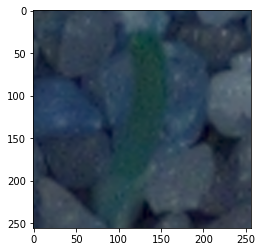

In [ ]:
plt.imshow(images[10])

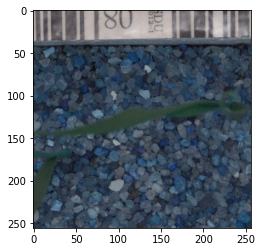

In [ ]:
plt.imshow(images[100])

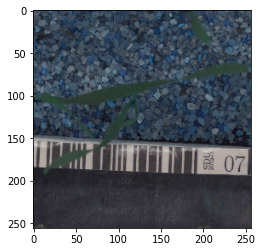

In [ ]:
plt.imshow(images[35])

Now lets see some images available in the Maize dataset.

In [ ]:
img = cv2.imread("train/Maize/00a18f05e.png")

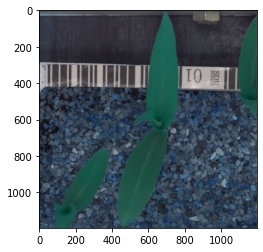

In [ ]:
plt.imshow(img)

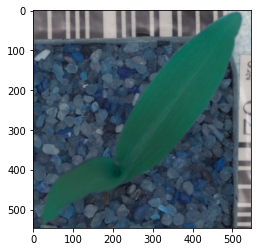

In [ ]:
plt.imshow(cv2.imread("train/Maize/44a9a599d.png"))

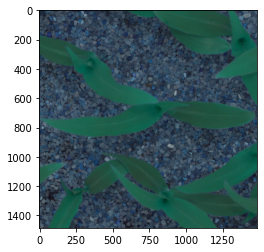

In [ ]:
plt.imshow(cv2.imread("train/Maize/030e7f9ef.png"))

Also lets see the images available in the Charlock dataset.

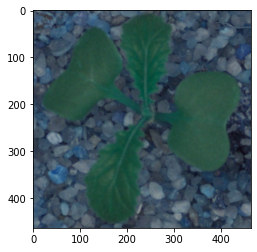

In [ ]:
plt.imshow(cv2.imread("train/Charlock/1aae936b7.png"))

Same for Common wheat dataset.

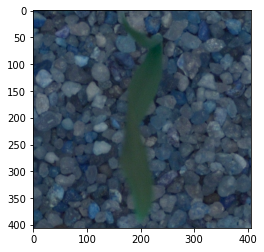

In [ ]:
plt.imshow(cv2.imread("train/Common wheat/ec0d252e7.png"))

# So for we have seen the images available in the dataset through different visualization technique. Now we have some basic understanding about the dataset and images available in the database. 

# Now its time to perform some task on these images so that we can analyse it. For that we need to convert these images into the number so that computer can perform task on it. So that we'll do here some Image-preprocessing. That will convert images from RGB to HSV and transform the data.

In [ ]:
def mask(image):
    h = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    sensitivity = 35
    x = np.array([60 - sensitivity, 100, 50])
    y = np.array([60 + sensitivity, 255, 255])
    z = cv2.inRange(h, x, y)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    z = cv2.morphologyEx(z, cv2.MORPH_CLOSE, k)    
    return z

Now lets apply segmentation on the images.

In [ ]:
def plant(image):
    x = mask(image)
    output = cv2.bitwise_and(image, image, mask = x)
    return output

Now after applying the segmentations on the images we'll here apply the sharpening on the image data.

In [ ]:
def sharpen(image):
    b = cv2.GaussianBlur(image, (0, 0), 3)
    s = cv2.addWeighted(image, 1.5, b, -0.5, 0)
    return s

As we have applied some transformation on the image datset. We have applied segmentation as well as sharpening on the images . so now lets combining all the functions in to one and see.

In [ ]:
def preprocess(img):
  image_segmented = plant(img)
  image_sharpen = sharpen(image_segmented)
  return image_sharpen
for a, image in enumerate(images):
  try:
    images[a] = preprocess(image)      
  except:
    print(a)
    continue

As we have combined all the images lets see the number of columns available in the dataset.

In [ ]:
column_size = images[1].shape[0] * images[1].shape[1]

In [ ]:
column_size

65536

**As we are seeing here that there are 65536 columns available in the dataset.**

# So for we have done some analysis on the training dataset. So lets import the test image data and exlore about that.Also we need to resize this into the dimension of 256*256 as we have done earlier for training dataset.

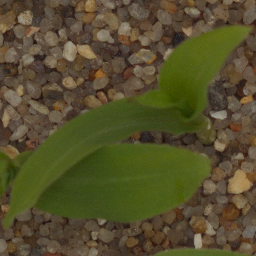

In [ ]:
 a = cv2.imread('/content/drive/MyDrive/AIML Program/Project/CV 1 - Project/Predict.png')
compresssed = cv2.resize(a,(256,256), interpolation = cv2.INTER_CUBIC)
cv2_imshow(compresssed)
tested = np.expand_dims(compresssed, axis=0)

In [ ]:
a.shape

(578, 578, 3)

In [ ]:
tested.shape

(1, 256, 256, 3)

As we can see here that initially the image size was 578, 578 but we have resized the image in the dimension of 256, 256

# As we know that our target labels are the categoral type of dataset. so we need
to encode them. that can convert them into a number. for that we'll use Label encoder.Label Encoding is a popular encoding technique for handling categorical variables. In this technique, each label is assigned a unique integer based on alphabetical ordering.

In [ ]:
coder = LabelEncoder()
y = coder.fit_transform(classes)
check = len(np.unique(y))
check

12

Now we applied the encoder on the target dataset.

So its time to segregate the dataset in to the training and testing dataset.

Here we have used 70 % data as training and 30 % data as testing dataset. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

Now lets Create validation set. For that we are splitting test and validation sets each with 50% of data

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=2)

In [ ]:
X_train

array([[[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [26, 82, 62],
         [34, 89, 66],
         [32, 84, 67]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [39, 90, 70],
         [26, 82, 60],
         [38, 88, 72]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [46, 92, 78],
         [36, 85, 68],
         [38, 86, 74]],

        ...,

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]]],


       [[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0, 

In [ ]:
X_train.shape

(3336, 256, 256, 3)

In [ ]:
y_train.shape

(3336,)

In [ ]:
X_test.shape

(715, 256, 256, 3)

In [ ]:
y_test.shape

(715,)

# So we have done all the task with training and testing dataset. So Now, we will move to the data modelling part, where we will train various models for image prediction.

In [ ]:
def flatten(a):
  Xr, Xg, Xb = [],[],[]
  for i in a:
    r, g, b = cv2.split(i)
    Xr.append(r.flatten())
    Xg.append(g.flatten())
    Xb.append(b.flatten())
  Xr = np.array(Xr)
  Xg = np.array(Xg)
  Xb = np.array(Xb)
  return (Xr, Xg, Xb)

In [ ]:
X_train_r, X_train_g, X_train_b = flatten(X_train)
X_test_r, X_test_g, X_test_b = flatten(X_test)
X_val_r, X_val_g, X_val_b = flatten(X_val)

Above, we can see that the images are split into r, g, b channels for all the train, test and validation datasets.

# As we know that there are 65536 number of columns are available in the dataset.So we can't take all the dataset. Thats we are taking here only 400 dataset. which we can easily handle.

# First of all we'll apply PCA on the traing dataset.

In [ ]:
X_train_pca_r = RandomizedPCA(n_components=400, whiten=True).fit(X_train_r)
X_train_pca_g = RandomizedPCA(n_components=400, whiten=True).fit(X_train_g)
X_train_pca_b = RandomizedPCA(n_components=400, whiten=True).fit(X_train_b)

Now we have applied on the traing data. Now its time for test dataset. So we'll apply PCA on the testing dataset.

In [ ]:
X_test_pca_r = RandomizedPCA(n_components=400, whiten=True).fit(X_test_r)
X_test_pca_g = RandomizedPCA(n_components=400, whiten=True).fit(X_test_g)
X_test_pca_b = RandomizedPCA(n_components=400, whiten=True).fit(X_test_b)

So we'll apply same on validation data as well.

In [ ]:
X_val_pca_r = RandomizedPCA(n_components=400, whiten=True).fit(X_val_r)
X_val_pca_g = RandomizedPCA(n_components=400, whiten=True).fit(X_val_g)
X_val_pca_b = RandomizedPCA(n_components=400, whiten=True).fit(X_val_b)

Now we'll apply transform function on all the datasets i.e. training, testing and validation datasets.

In [ ]:
Xr_train_pca = X_train_pca_r.transform(X_train_r)
Xg_train_pca = X_train_pca_g.transform(X_train_g)
Xb_train_pca = X_train_pca_b.transform(X_train_b)

On testing data

In [ ]:
Xr_test_pca = X_test_pca_r.transform(X_test_r)
Xg_test_pca = X_test_pca_g.transform(X_test_g)
Xb_test_pca = X_test_pca_b.transform(X_test_b)

On validating data

In [ ]:
Xr_val_pca = X_val_pca_r.transform(X_val_r)
Xg_val_pca = X_val_pca_g.transform(X_val_g)
Xb_val_pca = X_val_pca_b.transform(X_val_b)

# Now we have applied the PCA on the all the dataset. So Now its time for them to combine and make them in a single variable. 

So here we are gonna apply on training data

In [ ]:
X_train_pca = np.concatenate([Xr_train_pca,Xg_train_pca,Xb_train_pca], axis=1)

same for test data

In [ ]:
X_test_pca = np.concatenate([Xr_test_pca,Xg_test_pca,Xb_test_pca], axis=1)

same for validation dataset

In [ ]:
X_val_pca = np.concatenate([Xr_val_pca,Xg_val_pca,Xb_val_pca], axis=1)

SO Now we have combined them all in to one dataset. SO lets see the shape of them.

In [ ]:
X_train_pca.shape, y_train.shape,
X_test_pca.shape, y_test.shape,
X_val_pca.shape, y_val.shape

((716, 1200), (716,))

So here size is 1200 i.e. each set of 400. thats why 1200

# So Now, We will train a model here. 

# So here we are going to train the Supervised learning model first. So first of all we will use Support vector machine model as a supervised learning model. And will see the performance of it

In [ ]:
parameter = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},]
model_ = SVC()
clf = GridSearchCV(model_, parameter, verbose=10, n_jobs=-1)
clf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             verbose=10)

In [ ]:
X_train.shape[0]

3336

In [ ]:
y_train.shape[0]

3336

In [ ]:
svm_score = clf.score(X_val_pca, y_val)

In [ ]:
y_pred = clf.predict(X_test_pca)
svm_accuracy = metrics.accuracy_score(y_test, y_pred)
svm_accuracy

0.4

here we have are Predicting using SVM Classifier Model

We will perform PCA for the test image as well following the same procedure as we did for training data.

In [ ]:
pred_img = np.squeeze(tested, axis=0)
X_pred_r, X_pred_g, X_pred_b = cv2.split(pred_img)

In [ ]:
X_pred_pca_r = X_train_pca_r.transform(np.expand_dims(X_pred_r.flatten(), axis=0))
X_pred_pca_g = X_train_pca_g.transform(np.expand_dims(X_pred_g.flatten(), axis=0))
X_pred_pca_b = X_train_pca_b.transform(np.expand_dims(X_pred_b.flatten(), axis=0))

In [ ]:
X_pred_pca = np.concatenate([X_pred_pca_r,X_pred_pca_g,X_pred_pca_b], axis=1)

We'll now predict the unseen image using the SVM Classifier trained model. 

In [ ]:
result = clf.predict(X_pred_pca)[0]
result

7

# SO As we can see here that SVM model gave us accuracy of 40 % and its predicted the image as class 7.

# So we are gonna train another model to see the performance of that.

---



---

# So here we are going to train the random forest model to see the performance of that.



In [ ]:
parameter=[{'n_estimators':[100,200],'min_samples_leaf':[2,3]}]
model_ = RandomForestClassifier()
clf = GridSearchCV(model_, parameter, verbose=10, n_jobs=-1)
clf.fit(X_train_pca,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'min_samples_leaf': [2, 3],
                          'n_estimators': [100, 200]}],
             verbose=10)

In [ ]:
rf_score = clf.score(X_val_pca, y_val)
y_pred = clf.predict(X_test_pca)
rf_accuracy = metrics.accuracy_score(y_test, y_pred)
final = clf.predict(X_pred_pca)[0]

In [ ]:
rf_accuracy

0.48391608391608393

In [ ]:
final

1

## **So here we can see that RF classifier gave us accuracy of 48 % and its predicts the test image as class '1'. Its accuracy is greater than SVM accuracy.**



**So for, we have trained the SVM model and RF classifier and seen the accuracy of it. **

# Now we'll train the Neural Network. And will see the performance of that in the comparision of other models. 

First of all we'll erform labelbinarizer on the classes

In [ ]:
model_ = LabelBinarizer()
y2 = model_.fit_transform(classes)

And then Next, we'll split the data into train, test and validation sets.As have done earlier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)

Now divide the test data into validation data by 50-50 %

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=2)

In [ ]:
X_train

array([[[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [26, 82, 62],
         [34, 89, 66],
         [32, 84, 67]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [39, 90, 70],
         [26, 82, 60],
         [38, 88, 72]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [46, 92, 78],
         [36, 85, 68],
         [38, 86, 74]],

        ...,

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]]],


       [[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0, 

In [ ]:
X_train.shape

(3336, 256, 256, 3)

In [ ]:
y_train.shape

(3336, 12)

In [ ]:
num_classes = len(np.unique(y_train))

In [ ]:
num_classes

2

As we had applied the labelbinarizer that had converted the data label into 2 classes. thats why here number of classes are two i.e. 0 and 1. This will be used for output of NN model

# So now its time for build the ann model and apply it in the dataset.

In [ ]:
def ann_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  model = Sequential()
  model.add(InputLayer(input_shape=(height, width, num_channels)))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation = "softmax"))
  opt = tensorflow.keras.optimizers.Adam(learning_rate=0.000001)
  model.compile(optimizer = opt, loss = loss, metrics = metrics)
  model.summary()
  return model

In the ANN model we have used categorical crossentropy as a loss function and used the accuracy matrics. In the initial stages we have used the relu activation functions after that we have used the softmax activation functions. 
And we have used very low larning rate i.e. 0.000001

In [ ]:
ann = ann_model(256,256,3,12)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 batch_normalization (BatchN  (None, 196608)           786432    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              201327616 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 512)               5

Now lets fit the model

In [ ]:
result = ann.fit(X_train, y_train,epochs = 20,validation_data = (X_val,y_val),batch_size = None)

Epoch 1/20
105/105 [==============================] - 207s 2s/step - loss: 2.7071 - accuracy: 0.1769 - val_loss: 2.0745 - val_accuracy: 0.3142
Epoch 2/20
105/105 [==============================] - 206s 2s/step - loss: 2.1166 - accuracy: 0.3138 - val_loss: 1.6673 - val_accuracy: 0.4455
Epoch 3/20
105/105 [==============================] - 203s 2s/step - loss: 1.8948 - accuracy: 0.3714 - val_loss: 1.5090 - val_accuracy: 0.4916
Epoch 4/20
105/105 [==============================] - 201s 2s/step - loss: 1.7010 - accuracy: 0.4359 - val_loss: 1.4234 - val_accuracy: 0.5140
Epoch 5/20
105/105 [==============================] - 208s 2s/step - loss: 1.5136 - accuracy: 0.4865 - val_loss: 1.3400 - val_accuracy: 0.5461
Epoch 6/20
105/105 [==============================] - 206s 2s/step - loss: 1.4152 - accuracy: 0.5264 - val_loss: 1.3019 - val_accuracy: 0.5782
Epoch 7/20
105/105 [==============================] - 202s 2s/step - loss: 1.3185 - accuracy: 0.5579 - val_loss: 1.2470 - val_accuracy: 0.5908

In [ ]:
ann_loss, ann_accuracy = ann.evaluate(X_test, y_test, verbose=1)

23/23 [==============================] - 7s 315ms/step - loss: 1.0418 - accuracy: 0.6545


In [ ]:
ann_loss

1.041848063468933

In [ ]:
ann_accuracy

0.6545454263687134

**LEts make the performance by comfusion matrix**

In [ ]:
def visual(cm, classes,normalize=True,cmap=plt.cm.Blues):          
    plt.xticks(np.arange(len(classes)), classes)
    plt.yticks(np.arange(len(classes)), classes)   
    plt.ylabel('True_data')
    plt.xlabel('Predicted_data')  
    plt.imshow(cm, cmap=cmap)   
y = ann.predict(X_val)
x = np.argmax(y,axis = 1) 
z = np.argmax(y_val,axis = 1) 
pattern = confusion_matrix(z, x) 

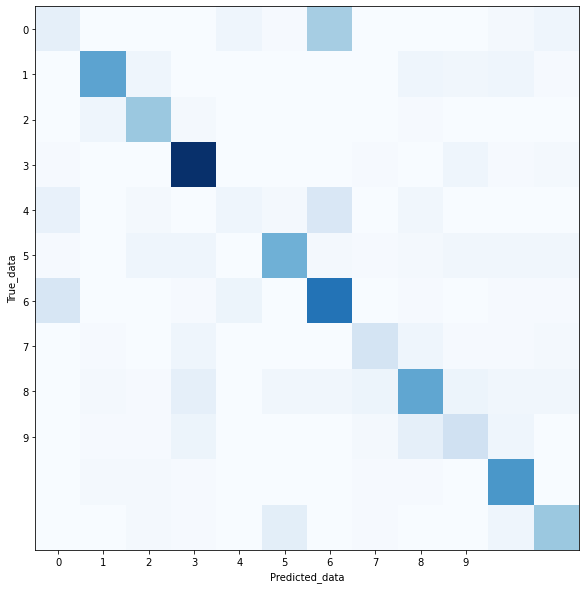

In [ ]:
plt.figure(figsize=(20,10))
visual(pattern, classes = range(10))

**Here we can see that dask area represent the more number while white area represnt the less number available there.**

# Predicting using ANN Classifier Model

In [ ]:
final = np.argmax(ann.predict(tested))

In [ ]:
final

1

CNN had predicted the label is "1"

# As we have seen from the above ANN model has an accuracy of 0.65 approximately and loss of 1.04 approximately. The loss is high. But we can  reduce it by modifying the ANN model by adding more dense layers and neurons. We can also try various learning rates of the optimizer.But as we can see here that its taking too  much time. thatswhy we'll move towards CNN. 

But we can do something better by above method.

# **Now we have seen the ANN model and its accuracy. Now we'll see the performance of CNN model.**

as we have already segregated the data. so here we'll only build the model and fir it.

In [ ]:
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']): 
  model = Sequential()
  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', batch_input_shape = (None,height, width, num_channels)))
  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))
  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))
  optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

Here we initialy we have used the relu activation functions then we have used the Softmax activation function. also we have used very slow learning rate i.e. 0.001. we can use further LR but it will take much time to train the model. Also here we have not done any padding with image data. i.e. imput and output images are same.

In [ ]:
cnn = cnn_model(256,256,3,12)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      36928     
                                                      

# Next, we'll train the CNN model with train data and validate the model using validation data. We have set the number of epochs as 5.

In [86]:
result = cnn.fit(X_train,y_train,epochs = 5,validation_data = (X_val,y_val),batch_size = None)

Epoch 1/5
105/105 [==============================] - 2179s 21s/step - loss: 3.0174 - accuracy: 0.1262 - val_loss: 2.4542 - val_accuracy: 0.1397
Epoch 2/5
105/105 [==============================] - 2166s 21s/step - loss: 2.3973 - accuracy: 0.1688 - val_loss: 2.2326 - val_accuracy: 0.2235
Epoch 3/5
105/105 [==============================] - 2097s 20s/step - loss: 2.1339 - accuracy: 0.2314 - val_loss: 2.1012 - val_accuracy: 0.2654
Epoch 4/5
105/105 [==============================] - 2078s 20s/step - loss: 2.0502 - accuracy: 0.2521 - val_loss: 2.0049 - val_accuracy: 0.3031
Epoch 5/5
105/105 [==============================] - 2100s 20s/step - loss: 1.9848 - accuracy: 0.2848 - val_loss: 1.9753 - val_accuracy: 0.2849


# We can increase the epochs size but as we can see here that 1 epoch is taking 35-40min to complete. So it'll take more than 3-4 hrs to get some good accuracy,But Now lets, we are going Evaluate the CNN Classifier Model

In [87]:
cnn_loss, cnn_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
cnn_loss

23/23 [==============================] - 94s 4s/step - loss: 1.9676 - accuracy: 0.3021


1.9675971269607544

Predicting using CNN Classifier Model

In [91]:
cnn_predict = np.argmax(cnn.predict(tested))

In [92]:
cnn_predict

5

CNN has predicted the class of 5

# As here we can see that with the CNN model we have got the 1.96 loss and accuracy of 31 % . But here we are also seeing that one epoches is taking 30-40mins to complete one session. SO if want to see some good accuracy with it then we'll have to increase the number of epoches. And we'll get good accuracy compared to other model. 
# New Section
# But while comparing the ANN and CNN model, just for 5 epoches. CNN model have good accuracy as compared to ANN model, thatswhy we can pick this model for our use.

# Now lets pickle this model. So we are gonna save it here in h5 format

In [93]:
cnn.save("CNN_Project.h5")

In [98]:
!pip install nbconvert

In [102]:
!jupyter nbconvert --to html CV_1_Project.ipynb

[NbConvertApp] WARNING | pattern 'CV_1_Project.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
  